<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/food__by_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ①foodシートの食品変数MILK1～SAKE6までの摂取量<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

### BMIメモ<br>
18.5未満	痩せ 鉄欠乏などの栄養不良による貧血のリスク<br>
18.5～25	普通 22のときが標準体重で、最も病気になりにくい<br>
25～30	肥満レベル1 25を超えると、脂質異常症や糖尿病、高血圧などの生活習慣病のリスクが2倍以上<br>
30～35	肥満レベル2 30を超えると高度な肥満として、より積極的な減量治療が必要<br>
35～40	肥満レベル3<br>
40～	肥満レベル4<br>

＊IDの重複削除とデータの結合、ECF,BMIの作成と欠損処理、異常値確認、LiNGAM

In [1]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

In [2]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [5]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [6]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = values_dataframe.corrwith(values_dataframe[df])
  correlations.sort_values(ascending=False)

In [7]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [8]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [9]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [10]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [11]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [12]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_food = pd.read_csv('./CSV/BDHQ 成人用フォーマット LongDataSet (food).csv')

In [13]:
print(len(data_nutr),len(data_food))

3329 2797


## ↓idの重複削除、結合

In [14]:
# data_food重複を確認
print("data_food で重複のある行数:", data_food['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_food で重複のある行数: 59
data_nutr で重複のある行数: 116


In [15]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [16]:
# 左結合
merged_data = pd.merge(data_food, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2797 entries, 0 to 2796
Columns: 182 entries, ID1 to filename_y
dtypes: float64(178), int64(1), object(3)
memory usage: 3.9+ MB
None


In [17]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

59

In [18]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
2738


In [19]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2796
Columns: 182 entries, ID1 to filename_y
dtypes: float64(178), int64(1), object(3)
memory usage: 3.8+ MB
None
2738


### ↓変数作成


In [20]:
## エネルギー補正係数とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加(ECF:Energy correction factor)
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['ECF'] = cleaned_data_copy['EER'] / cleaned_data_copy['EN']

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,ECF
0,201100001,2015.0,7.0,0.0,136.111524,39.132063,39.132063,27.222305,3.387665,41.740867,...,43.708411,22.084421,44.630987,46.242804,40.19382,39.545785,19.487288,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,23.214198,0.934649


In [21]:
# 変数を選択
selected_columns = cleaned_data_copy.loc[:, 'MILK1':'SAKE6'].copy()
selected_columns['BMI'] = cleaned_data_copy['BMI']
selected_columns['ECF'] = cleaned_data_copy['ECF']
selected_columns['AGE'] = cleaned_data_copy['AGE']
selected_columns['SEX'] = cleaned_data_copy['SEX']
values_dataframe = selected_columns

values_dataframe.describe()

,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,FISH2,FISH3,FISH4,...,MISO,SAKE2,SAKE3,SAKE4,SAKE5,SAKE6,BMI,ECF,AGE,SEX
count,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,...,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2710.000000,2710.000000,2710.000000,2710.000000
mean,34.764657,80.053713,23.631035,34.314375,8.926266,0.900346,12.274938,10.216225,4.194806,22.520833,...,179.497053,15.817197,79.613473,16.170111,3.313994,4.279675,22.857073,1.282921,53.947232,1.609963
std,66.259886,86.099265,22.957716,26.478498,9.045182,3.193298,16.541838,17.636710,6.338933,24.262516,...,131.107118,54.583057,194.906525,44.273592,17.352807,22.564087,3.506897,0.492430,19.101461,0.487848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917,0.259846,15.000000,1.000000
25%,0.000000,0.000000,7.968711,14.229841,2.309771,0.000000,5.520000,0.000000,0.000000,5.866667,...,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.406081,0.969508,41.000000,1.000000
50%,0.000000,53.571429,14.785714,30.803571,5.142857,0.000000,7.083299,4.781227,3.066667,13.198693,...,132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.456083,1.187820,58.000000,2.000000
75%,42.857143,136.111524,33.883929,39.132063,11.785714,0.000000,14.457143,10.842857,5.914286,31.428571,...,249.455301,0.000000,63.300000,1.928571,0.000000,0.000000,24.820016,1.476786,69.000000,2.000000
max,415.758836,415.758836,239.061331,239.061331,83.151767,92.390852,254.998753,191.249064,82.800000,192.000000,...,990.891892,540.000000,1899.000000,270.000000,201.000000,330.000000,50.781250,5.894433,96.000000,2.000000


In [22]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

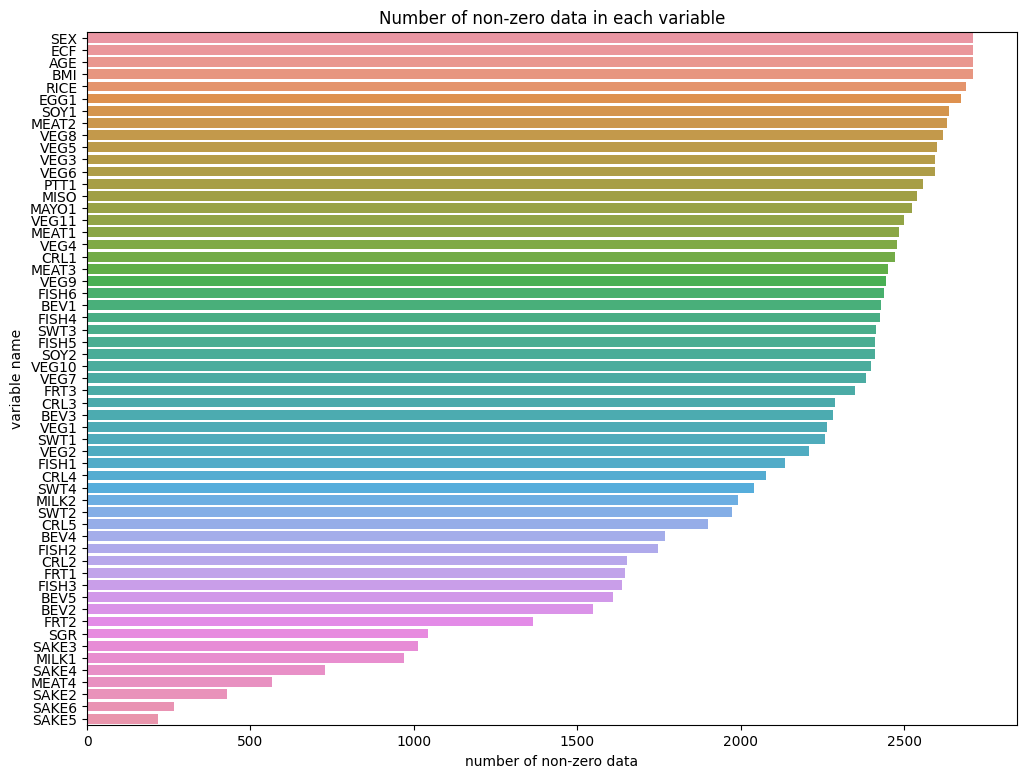

('VEG3', 'VEG5', 0.5111778005695479)
('VEG5', 'VEG3', 0.5111778005695479)
('VEG5', 'VEG6', 0.5423405377044409)
('VEG5', 'VEG7', 0.5130633464363883)
('VEG6', 'VEG5', 0.5423405377044409)
('VEG6', 'VEG8', 0.5394437595174767)
('VEG7', 'VEG5', 0.5130633464363883)
('VEG8', 'VEG6', 0.5394437595174767)
('RICE', 'MISO', 0.5631280489864002)
('MISO', 'RICE', 0.5631280489864002)


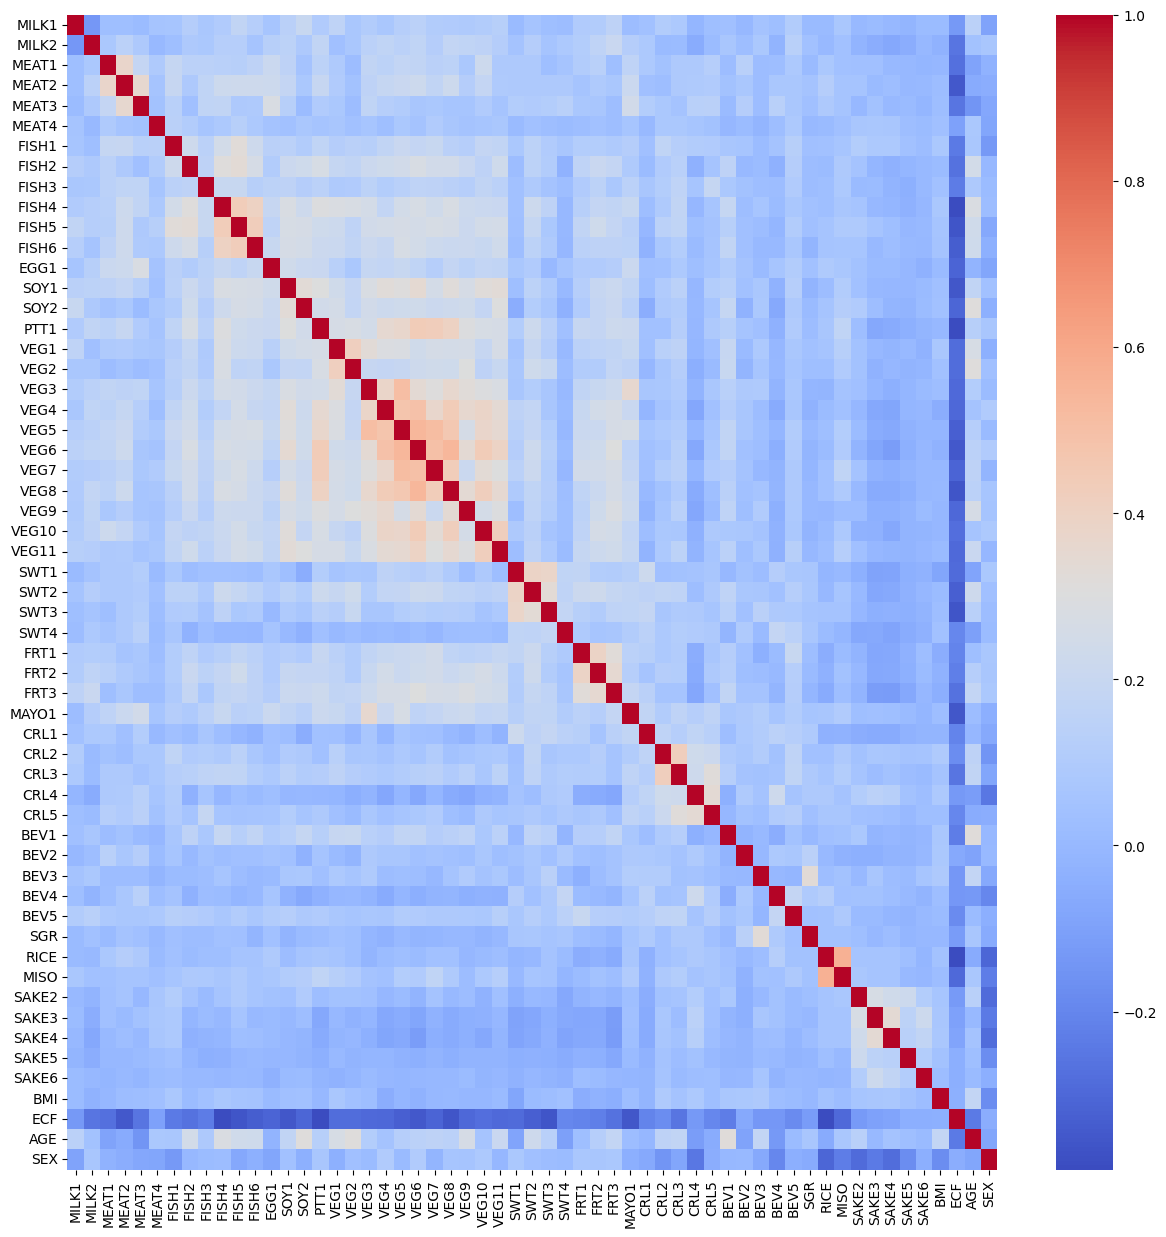

In [23]:
checksVariables(values_dataframe_cleaned)

### LiNGAMの関数定義

In [24]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [25]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n_________")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(p_values)

  return model

In [26]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [27]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [28]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [29]:
# # 変数とインデックス
# for index, column_name in enumerate(values_dataframe_cleaned.columns):
#     print(f"{index}:{column_name}",end=", ")
i=0
for column_name in values_dataframe_cleaned.columns:
  print(f"{column_name}",end='\t')
  if i==1 or i==5 or i==11 or i==12 or i==14 or i==15 or i==26 or i==30 or i==33 or i==34 or i==39 or i==44 or i==45 or i==46 or i==47 or i==52:
    print()
  i += 1

MILK1	MILK2	
MEAT1	MEAT2	MEAT3	MEAT4	
FISH1	FISH2	FISH3	FISH4	FISH5	FISH6	
EGG1	
SOY1	SOY2	
PTT1	
VEG1	VEG2	VEG3	VEG4	VEG5	VEG6	VEG7	VEG8	VEG9	VEG10	VEG11	
SWT1	SWT2	SWT3	SWT4	
FRT1	FRT2	FRT3	
MAYO1	
CRL1	CRL2	CRL3	CRL4	CRL5	
BEV1	BEV2	BEV3	BEV4	BEV5	
SGR	
RICE	
MISO	
SAKE2	SAKE3	SAKE4	SAKE5	SAKE6	
BMI	ECF	AGE	SEX	

In [30]:
# 変数を指定するリスト
selected_variables = ['RICE','EGG1','SOY1','MEAT2','VEG8','PTT1','CRL1','FISH6','ECF','BMI','SEX']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

,RICE,EGG1,SOY1,MEAT2,VEG8,PTT1,CRL1,FISH6,ECF,BMI,SEX
0,300.270270,83.844699,44.349671,39.132063,31.305650,127.037422,28.872141,83.481734,0.934649,23.214198,1.0
1,720.648649,91.466944,19.352584,85.379047,68.303237,69.293139,69.293139,45.535492,0.736540,25.854639,1.0
2,405.364865,76.222453,16.127153,35.574603,28.459682,23.097713,25.984927,7.083299,1.422898,19.568236,1.0
3,300.270270,59.889070,88.699343,39.132063,62.611301,127.037422,80.841996,7.791629,0.980858,29.384757,1.0
4,165.148649,32.666766,135.468087,42.689523,13.660647,27.717256,88.926195,18.214197,1.231252,22.340297,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2792,650.000000,47.142857,69.821429,61.607143,49.285714,100.000000,25.000000,32.857143,0.536910,21.938776,2.0
2793,390.000000,66.000000,34.910714,30.803571,24.642857,50.000000,25.000000,32.857143,1.112934,18.845467,2.0
2794,260.000000,47.142857,34.910714,30.803571,24.642857,50.000000,70.000000,13.142857,1.057415,23.415859,2.0
2795,351.000000,42.428571,62.839286,11.089286,22.178571,90.000000,22.500000,29.571429,0.904527,26.886957,2.0


In [31]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

              RICE         EGG1         SOY1        MEAT2         VEG8  \
count  2037.000000  2037.000000  2037.000000  2037.000000  2037.000000   
mean    304.643348    42.991576    54.287576    36.293834    43.262404   
std     154.843529    25.321039    39.826875    25.803136    32.943263   
min      52.000000     3.520000     5.213333     4.600000     3.680000   
25%     208.000000    23.571429    31.419643    24.642857    22.178571   
50%     300.270270    42.428571    40.317883    32.017142    31.305650   
75%     390.000000    59.889070    78.200000    39.132063    56.919364   
max    1441.297297   167.689397   270.936175   239.061331   191.249064   

              PTT1         CRL1        FISH6          ECF          BMI  \
count  2037.000000  2037.000000  2037.000000  2037.000000  2037.000000   
mean     63.118205    29.693427    23.787361     1.201825    22.788960   
std      53.252678    24.694530    22.766265     0.388371     3.320420   
min       7.466667     3.733333     4

### 男性女性に分けて実行

In [32]:
# 男女に分ける
male_df = df[df['SEX']==1].drop('SEX',axis=1)
female_df = df[df['SEX']==2].drop('SEX',axis=1)

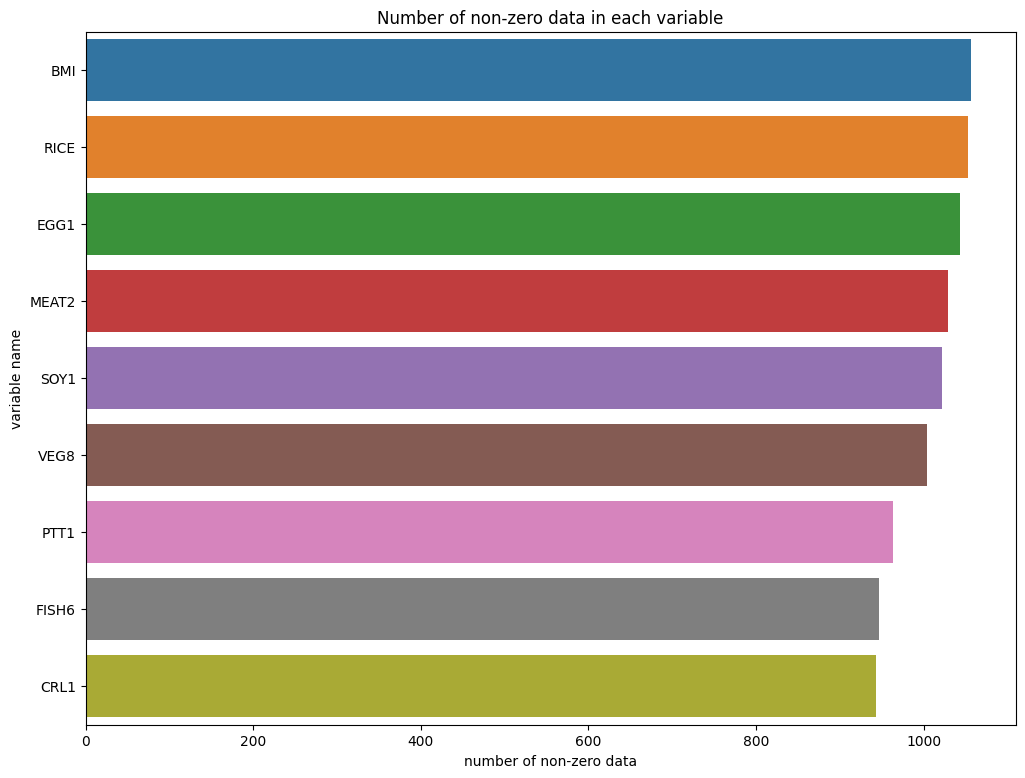

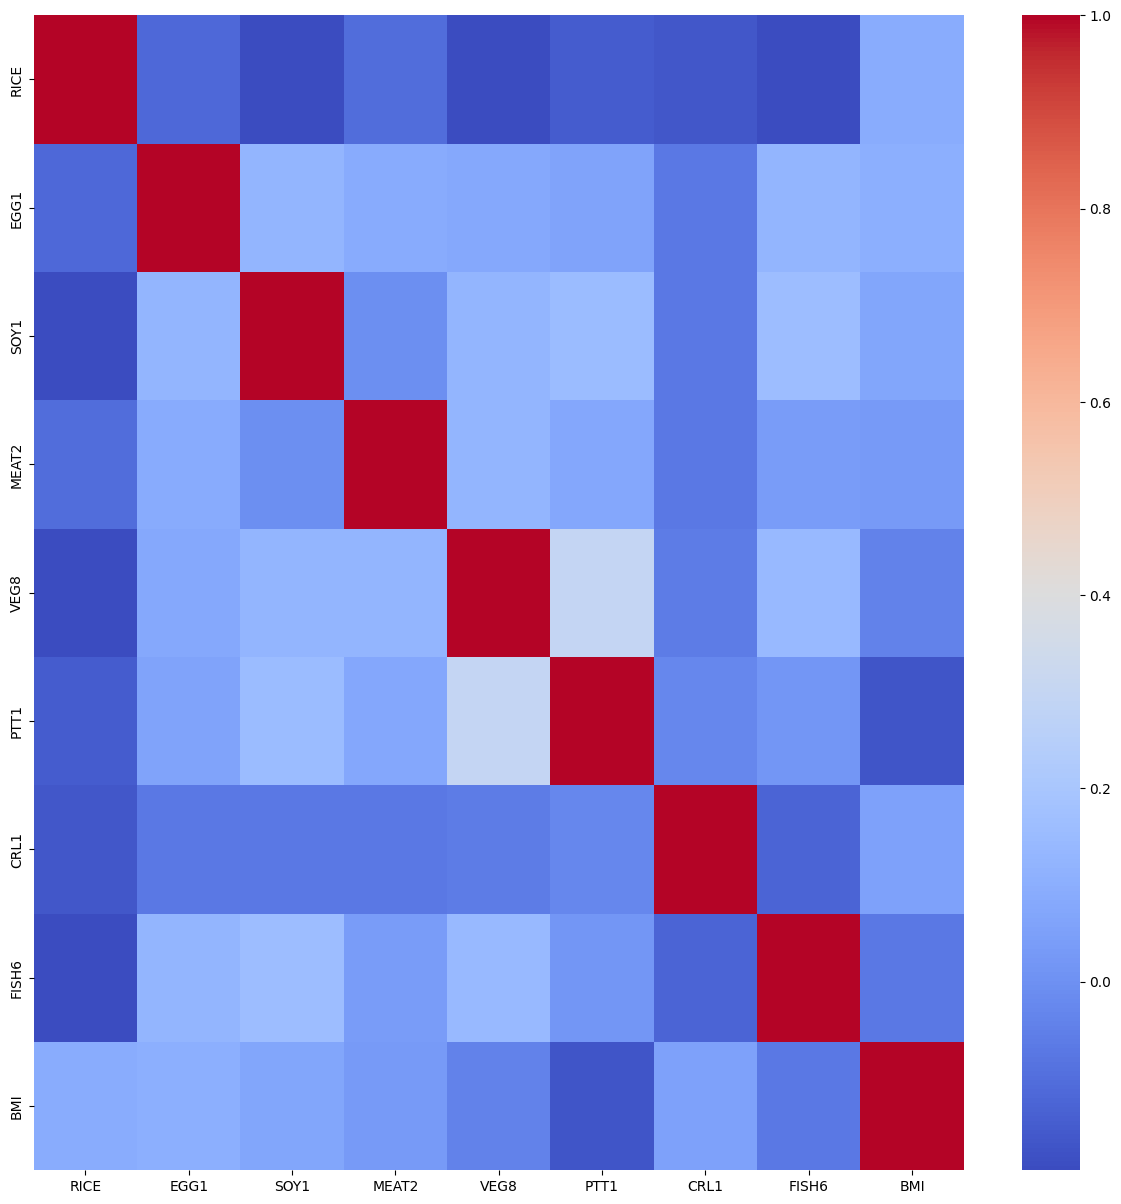

In [33]:
 # ECF列を掛ける
multiplied_male_df = male_df.drop('ECF', axis=1).multiply(male_df['ECF'], axis=0)
# print(multiplied_male_df.describe())
checksVariables(multiplied_male_df)

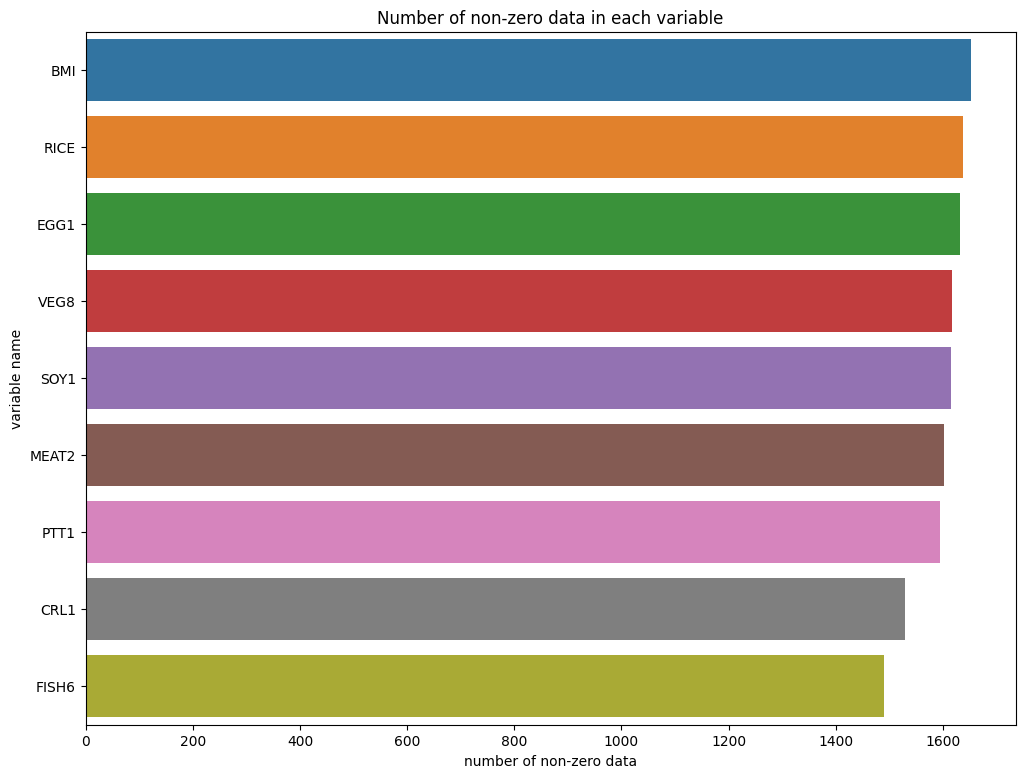

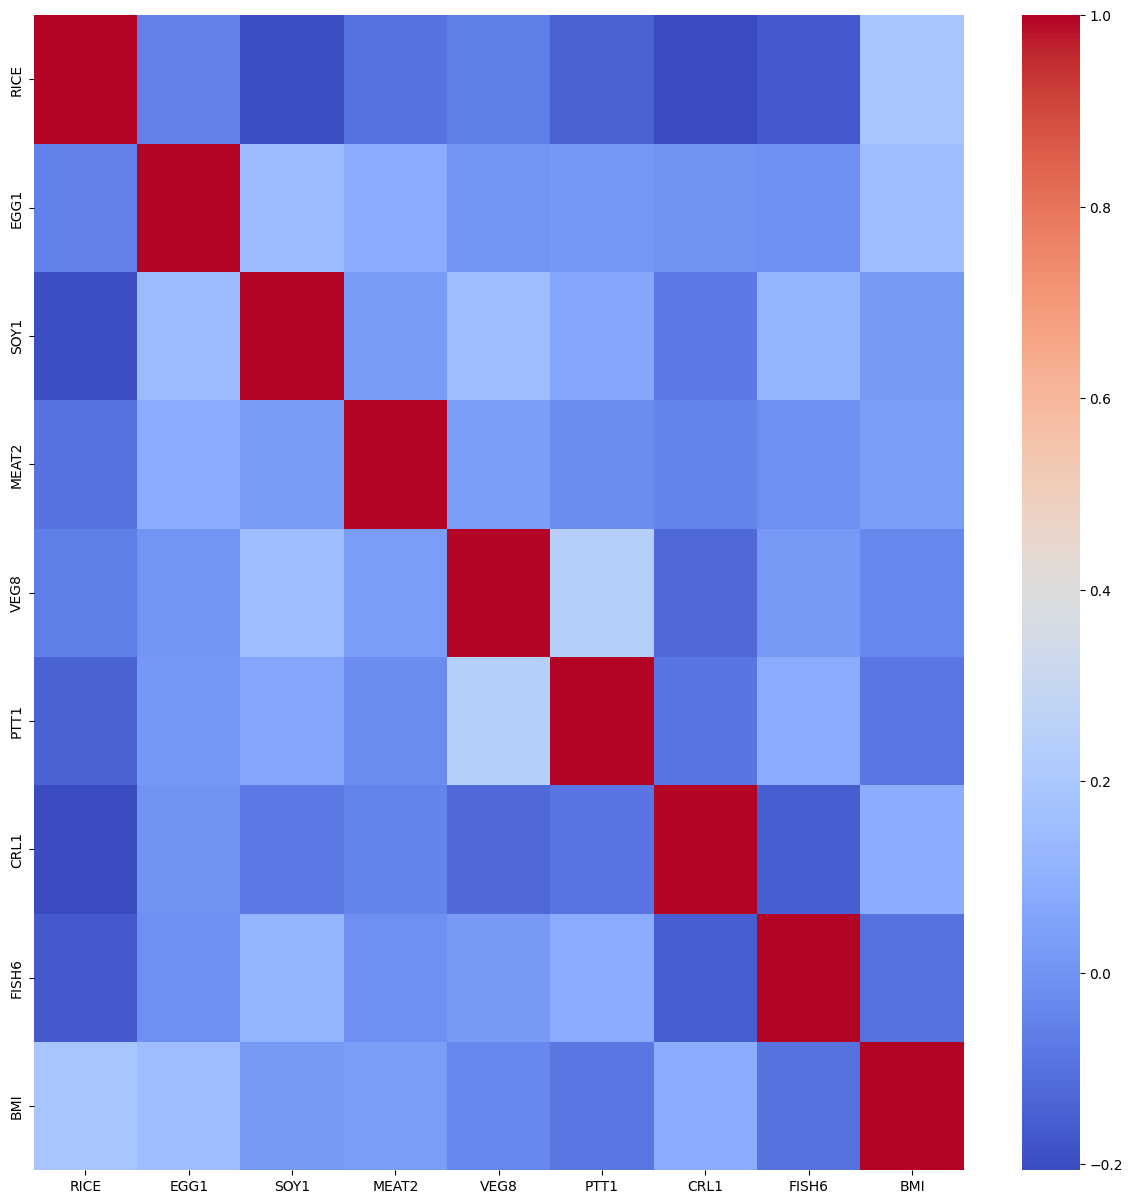

In [34]:
# ECF列を掛ける
multiplied_female_df = female_df.drop('ECF', axis=1).multiply(female_df['ECF'], axis=0)
# print(multiplied_female_df.describe())
checksVariables(multiplied_female_df)

因果の順番
[7, 6, 2, 1, 3, 8, 5, 4, 0]

_________
隣接行列
[[ 0.          0.         -0.16986392  0.         -0.1838073   0.
  -0.18077028 -0.19331527  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.12239618  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.1313634   0.          0.28894233
   0.          0.          0.        ]
 [ 0.          0.11313802  0.17967308  0.          0.          0.
   0.          0.         -0.12800002]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.1142396   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.       

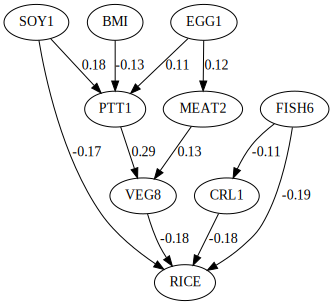

In [35]:
male_dot,male_prob = LiNGAM(multiplied_male_df,'food_male_data')
male_dot

In [36]:
male_prob

,from,to,effect,probability
0,CRL1,RICE,-0.160001,0.98
1,SOY1,RICE,-0.186126,0.96
2,FISH6,RICE,-0.193735,0.95
3,VEG8,RICE,-0.181113,0.93
4,PTT1,VEG8,0.282285,0.84
...,...,...,...,...
57,VEG8,EGG1,0.127439,0.02
58,EGG1,FISH6,0.122065,0.01
59,PTT1,CRL1,0.096365,0.01
60,EGG1,CRL1,-0.104746,0.01


因果の順番
[7, 6, 3, 5, 2, 1, 0, 4, 8]

_________
隣接行列
[[ 0.          0.         -0.18035907 -0.06213464  0.         -0.16191453
  -0.2413292  -0.18823803  0.        ]
 [ 0.          0.          0.14914621  0.07301309  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.08735006
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-0.06392678  0.          0.14934103  0.08824342  0.          0.21274255
  -0.10555206  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.08626199  0.08225149  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.13642903  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.22620599  0.1399504   0.          0.07785746  0.         -0.05519747
   0.1203393

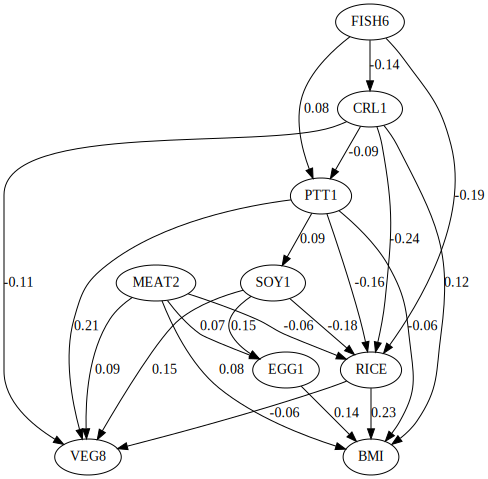

In [37]:
female_dot,female_prob = LiNGAM(multiplied_female_df,'food_female')
female_dot

In [38]:
female_prob

,from,to,effect,probability
0,CRL1,RICE,-0.208960,1.00
1,FISH6,RICE,-0.188385,1.00
2,RICE,BMI,0.227063,0.99
3,EGG1,BMI,0.139044,0.98
4,CRL1,VEG8,-0.124260,0.93
5,SOY1,EGG1,0.151624,0.87
6,FISH6,CRL1,-0.138566,0.73
7,PTT1,VEG8,0.232672,0.71
8,CRL1,PTT1,-0.096825,0.69
9,MEAT2,VEG8,0.112141,0.67
